Feature Engineering and Data prep

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("behrad3d/nasa-cmaps")

print("Path to dataset files:", path)

Path to dataset files: /Users/jonathantsegaye/.cache/kagglehub/datasets/behrad3d/nasa-cmaps/versions/1


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotx
# train1
data = []
train1_path = path + "/CMaps/train_FD001.txt"
test1_path = path + "/CMaps/test_FD001.txt"
rul1_path = path + "/CMaps/RUL_FD001.txt"


train_df = pd.read_csv(train1_path, sep= " ", header=None)
test_df = pd.read_csv(test1_path, sep= " ", header=None)
rul_df = pd.read_csv(rul1_path, sep= " ", header=None)

In [3]:
train_df.drop(columns=[26, 27], inplace=True)
test_df.drop(columns=[26, 27], inplace=True)
rul_df.drop(columns=[1], inplace=True)

In [4]:
columns = ["unit_no", "cycles", "op1", "op2", "op3", "T2", "T24", "T30", "T50", "P2", "P15", "P30", "Nf", "Nc", "epr", "Ps30", "phi", "NRf", "NRc", "BPR", "farB", "htBleed", "Nf_dmd", "PCNfR_dmd", "W31", "W32"]
train_df.columns = columns
test_df.columns = columns

In [5]:
train_df.describe()

,unit_no,cycles,op1,op2,op3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [6]:
data_train = train_df.copy()
train_df['RUL'] = train_df.groupby('unit_no')['cycles'].transform(lambda x: x.max() - x)

Text(0.5, 1.0, 'Distribution of Remaining Useful Life')

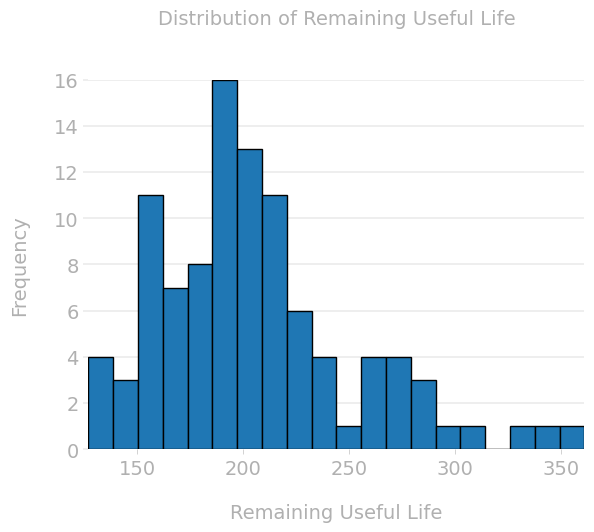

In [7]:
plt.style.use(matplotx.styles.dufte)

rul_values = train_df.groupby('unit_no').max().reset_index()['RUL']

plt.hist(x=rul_values, bins=20, edgecolor="black")
plt.ylabel(ylabel="Frequency")
plt.xlabel(xlabel="Remaining Useful Life")
plt.title("Distribution of Remaining Useful Life")

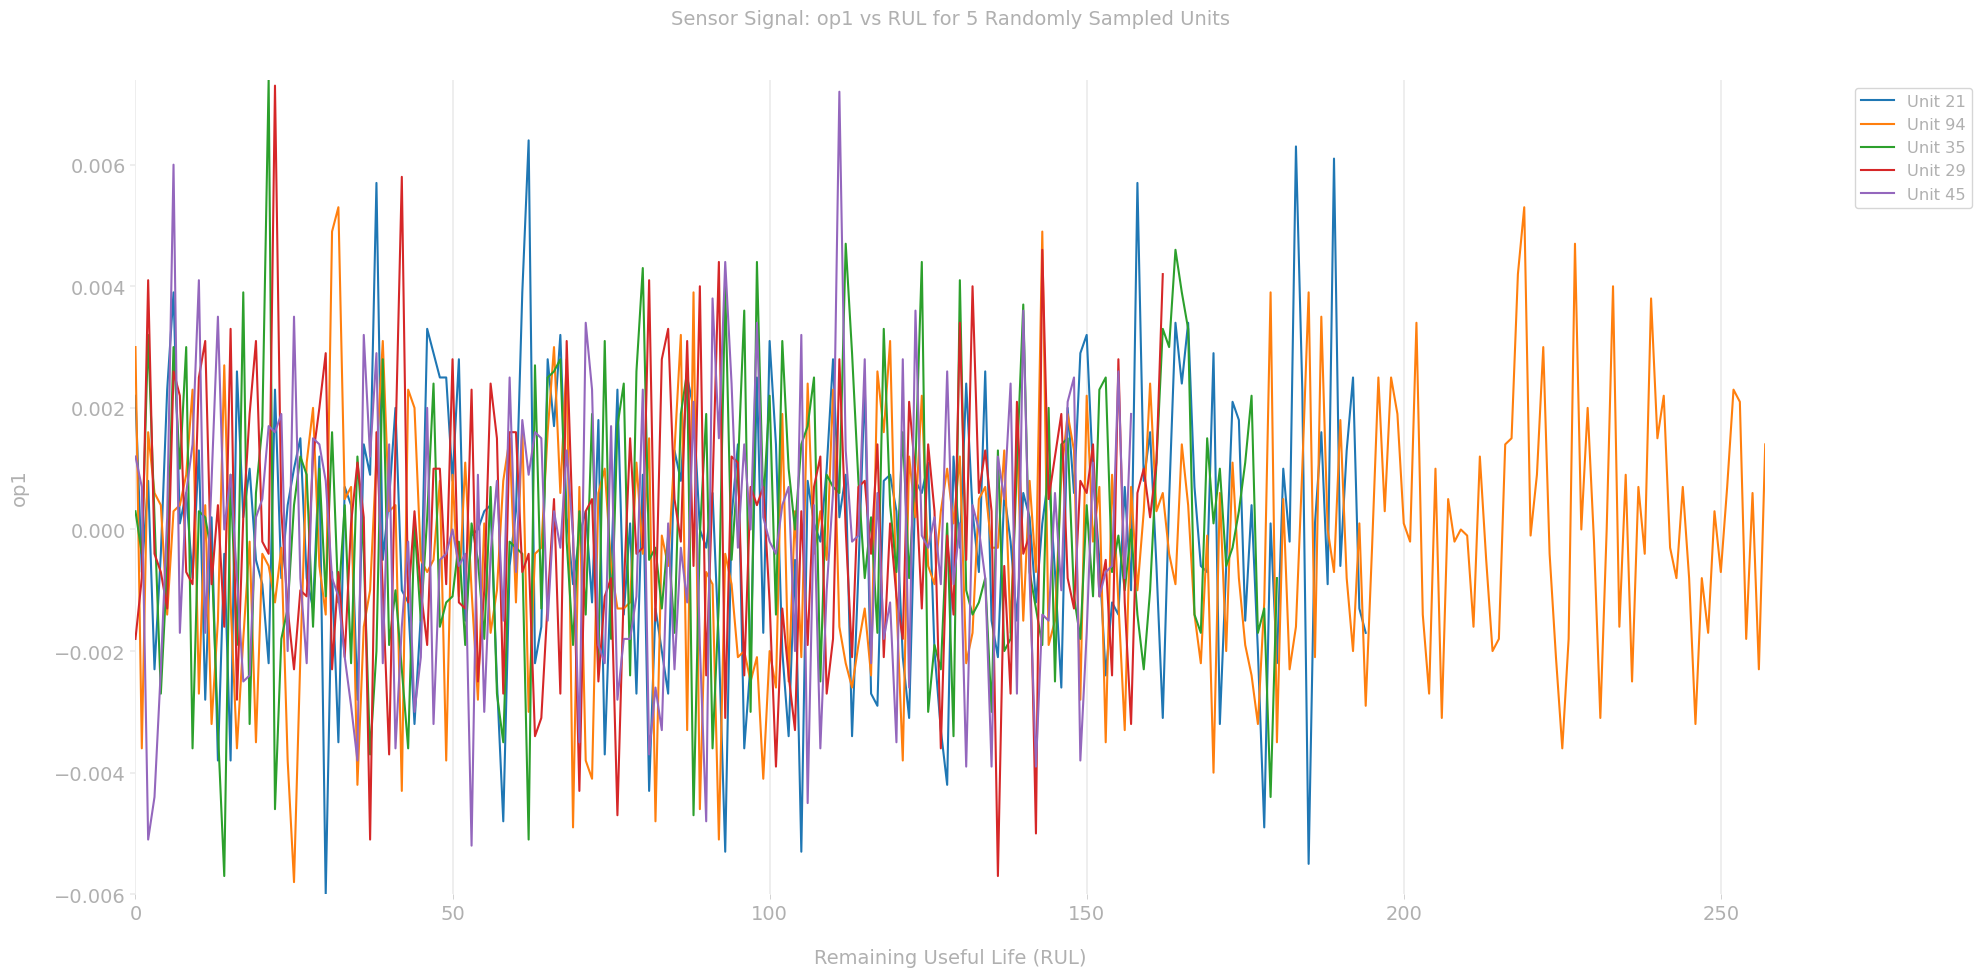

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already loaded the data into a DataFrame named train_df
columns = ["unit_no", "cycles", "op1", "op2", "op3", "T2", "T24", "T30", "T50", "P2", "P15", "P30", 
           "Nf", "Nc", "epr", "Ps30", "phi", "NRf", "NRc", "BPR", "farB", "htBleed", "Nf_dmd", 
           "PCNfR_dmd", "W31", "W32", "RUL"]

# Randomly sample 5 unique units
unit_ids = np.random.choice(train_df["unit_no"].unique(), size=5, replace=False)

# Define the sensor/feature to plot
sensor_to_plot = "op1"  # Replace this with the column for the 7th sensor

plt.figure(figsize=(20, 10))

for unit_id in unit_ids:
    unit_data = train_df[train_df["unit_no"] == unit_id]
    plt.plot(unit_data["RUL"], unit_data[sensor_to_plot], label=f"Unit {unit_id}")

# Customize the plot
plt.xlabel("Remaining Useful Life (RUL)")
plt.ylabel(sensor_to_plot)
plt.title(f"Sensor Signal: {sensor_to_plot} vs RUL for 5 Randomly Sampled Units")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
train = np.array(train_df.drop(columns=["RUL"]))
targets = np.array(train_df['RUL'])

In [10]:
len(train[0])

26

In [11]:
targets[0:10]

array([191, 190, 189, 188, 187, 186, 185, 184, 183, 182])

In [12]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [13]:
from torch.utils.data import Dataset, DataLoader

class RULDataset(Dataset):
    def __init__(self, data, targets, unit_column, window_length, shift):
        self.data = data
        self.targets = targets
        self.unit_column = unit_column
        self.window_length = window_length
        self.shift = shift
        self.samples = self.__generate_samples()

    def __generate_samples(self):
        samples = []
        unique_units = np.unique(self.data[:, self.unit_column])
        for unit in unique_units:
            unit_data = self.data[self.data[:, self.unit_column] == unit]
            unit_targets = process_targets(len(unit_data), early_rul=100)
            for start_idx in range(0, len(unit_data) - self.window_length + 1, self.shift):
                end_idx = start_idx + self.window_length
                samples.append(((unit_data[start_idx:end_idx, 1:], unit_targets[end_idx - 1])))
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [14]:
train_dataset = RULDataset(data=train, targets=targets, unit_column=0, window_length=30, shift=1)
dataloader = DataLoader(train_dataset, batch_size = 128, shuffle=True)

In [15]:
train_dataset[0][0].shape

torch.Size([30, 25])

In [16]:
for batch_data, batch_targets in dataloader:
    print(batch_data.shape)  # Shape: (batch_size, window_length, num_features)
    break


torch.Size([128, 30, 25])


In [17]:
import torch.nn as nn
import torch.nn.functional as F


# 2k MSE
# class RULModel(nn.Module):
#     def __init__(self):
#         super(RULModel, self).__init__()
#         self.fc1 = nn.Linear(26, 26 * 4)
#         self.fc2 = nn.Linear(26 * 4, 26)
#         self.fc3 = nn.Linear(26, 1)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         return x

# 1k MSE
class RULModel(nn.Module):
    def __init__(self):
        super(RULModel, self).__init__()
        self.lstm1 = torch.nn.LSTM(input_size=25, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = torch.nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 1)
    

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

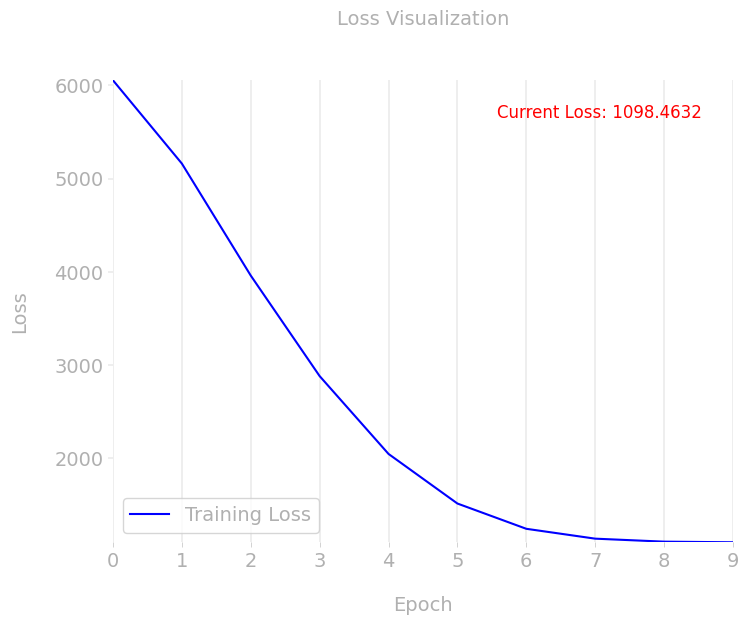

In [18]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

model = RULModel()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduces LR by 10% every 5 epochs
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epoch_losses = []

# uncomment when done testing notebook
# with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for data, labels in dataloader:
        data, labels = data.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)

        # Forward pass
        pred = model(data)
        loss = loss_fn(pred, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # scheduler.step()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    epoch_losses.append(avg_epoch_loss)

    # uncomment when done with testing notebook
    # pbar.set_postfix({"Epoch Loss": f"{avg_epoch_loss:.4f}"})
    # pbar.update(1)

    # live loss plot
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.plot(epoch_losses, label="Training Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Visualization")
    plt.legend()
    plt.grid()

    plt.text(0.95, 0.95, f"Current Loss: {avg_epoch_loss:.4f}",
            color="red", fontsize=12, ha="right", va="top", transform=plt.gca().transAxes)

    plt.show()
